# load

> Module for loading training and target files

In [64]:
#| default_exp load

In [65]:
#| hide
from nbdev.showdoc import *

In [66]:
#| export

import numpy as np
import pkg_resources
from sepia.SepiaData import SepiaData
from scipy.signal import savgol_filter

In [67]:
#| hide

import matplotlib.pylab as plt

In [68]:
#| export

DATA_DIR = "data/"
LIBRARY_ZK_FILE = pkg_resources.resource_stream("CubicGalileonEmu", DATA_DIR + "z_k.txt").name
LIBRARY_BK_FILE = pkg_resources.resource_stream("CubicGalileonEmu", DATA_DIR + "Boost.npy").name
LIBRARY_BKLIN_FILE = pkg_resources.resource_stream("CubicGalileonEmu", DATA_DIR + "Boost_Lin.npy").name

LIBRARY_PARAM_FILE = pkg_resources.resource_stream("CubicGalileonEmu", DATA_DIR + "cosmo_newdesign.txt").name
# PARAM_NAME = [r"$\Omega_m h^2$", r"$n_s$", r"$\sigma_8$", r"$E_{ds}$", r"$f_\phi$"]
PARAM_NAME = [r"$\Omega_m$", r"$n_s$", r"$10^{9} A_s$", r"$h$", r"$f_\phi$"]

LIBRARY_ZK_FILE_VAL = pkg_resources.resource_stream("CubicGalileonEmu", DATA_DIR + "z_k_validation.txt").name
LIBRARY_BK_FILE_VAL = pkg_resources.resource_stream("CubicGalileonEmu", DATA_DIR + "Boost_validation.npy").name
LIBRARY_PARAM_FILE_VAL = pkg_resources.resource_stream("CubicGalileonEmu", DATA_DIR + "cosmo_validation.txt").name


In [69]:
#| export

def smooth_func(f_in:np.ndarray=None # Unsmoothed array
                ) -> np.ndarray: # Smoothed array
    # window size 51, polynomial order 3
    window_size = 17
    polynomial_order = 3

    f_out = np.zeros_like(f_in)
    for sim_index in range(f_in.shape[0]):
        f_out[sim_index] = savgol_filter(f_in[sim_index], window_size, polynomial_order)
    
    return f_out

In [70]:
#| export

def load_boost_data(Bk_fileIn:str=LIBRARY_BK_FILE, # Input file for Boost
                        Zk_fileIn:str=LIBRARY_ZK_FILE, # Input file for redshift and wavenumbers
                        ) -> tuple: # Boost, wavenumbers, redshifts 
    Bk_all = np.load(Bk_fileIn)
    zk_all = np.loadtxt(Zk_fileIn)
    
    z_all = zk_all[:, 0][np.isfinite(zk_all[:, 0])]
    k_all = zk_all[:, 1]

    # z_all_argsort = np.argsort(z_all)
    # z_all = z_all[z_all_argsort]
    # Bk_all = Bk_all[:, z_all_argsort, :]

    # k_select = np.where(k_all <= 4.0)
    # Bk_all = Bk_all[:, :, k_select]
    # k_all = k_all[k_select]

    Bk_all = smooth_func(Bk_all)

    
    return Bk_all, k_all, z_all

In [71]:
#| export

def load_boost_data_lin(Bk_fileIn:str=LIBRARY_BKLIN_FILE, # Input file for Boost
                        Zk_fileIn:str=LIBRARY_ZK_FILE, # Input file for redshift and wavenumbers
                        ) -> tuple: # Boost, wavenumbers, redshifts 
    Bk_all = np.load(Bk_fileIn)
    zk_all = np.loadtxt(Zk_fileIn)
    
    z_all = zk_all[:, 0][np.isfinite(zk_all[:, 0])]
    k_all = zk_all[:, 1]    
    return Bk_all, k_all, z_all

In [72]:
#| export

def load_params(p_fileIn:str=LIBRARY_PARAM_FILE, # Input file for parameters
               ) -> np.array: # Parameters
    p_all = np.loadtxt(p_fileIn)
    p_all[:, 2] = p_all[:, 2]/1e-9  # A_s rescaling
    return p_all

In [73]:
#| hide

Bk_all, k_all, z_all = load_boost_data()
# Bk_all, k_all, z_all = load_boost_data_lin()
p_all = load_params()

In [74]:
#| hide 

Bk_all.shape, k_all.shape, z_all.shape, p_all.shape

((50, 51, 768), (768,), (51,), (50, 5))

[5.00000000e+01 2.45000000e+01 1.60000000e+01 1.17500000e+01
 9.20000000e+00 7.50000000e+00 6.28571429e+00 5.37500000e+00
 4.66666667e+00 4.10000000e+00 3.63636364e+00 3.25000000e+00
 2.92307692e+00 2.64285714e+00 2.40000000e+00 2.18750000e+00
 2.00000000e+00 1.83333333e+00 1.68421053e+00 1.55000000e+00
 1.42857143e+00 1.31818182e+00 1.21739130e+00 1.12500000e+00
 1.04000000e+00 9.61538462e-01 8.88888889e-01 8.21428571e-01
 7.58620690e-01 7.00000000e-01 6.45161290e-01 5.93750000e-01
 5.45454545e-01 5.00000000e-01 4.57142857e-01 4.16666667e-01
 3.78378378e-01 3.42105263e-01 3.07692308e-01 2.75000000e-01
 2.43902439e-01 2.14285714e-01 1.86046512e-01 1.59090909e-01
 1.33333333e-01 1.08695652e-01 8.51063830e-02 6.25000000e-02
 4.08163265e-02 2.00000000e-02 0.00000000e+00]


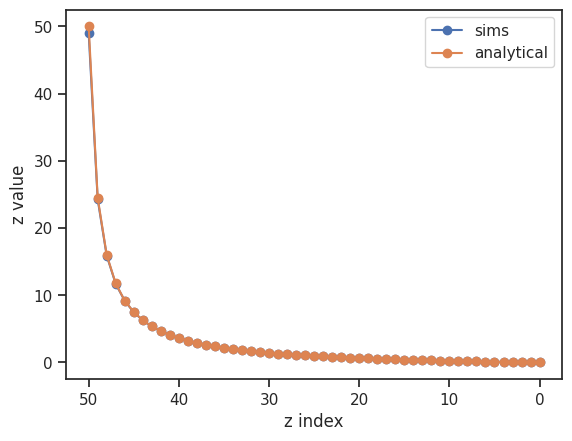

In [75]:
#| hide 

z_init = 50
a_init = 1/(1 + z_init)
a_final = 1

num_timesteps = 51
a_all = np.linspace(a_final, a_init, num_timesteps)
z_all_new = (1./a_all) - 1 


plt.plot( z_all, '-o', label='sims')
plt.xlabel('z index')
plt.ylabel('z value')
plt.plot(z_all_new, '-o', label='analytical')
plt.gca().invert_xaxis()
plt.legend()

print(z_all_new[::-1])

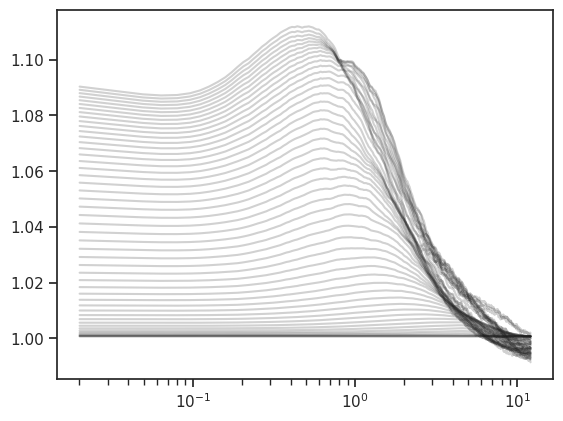

In [76]:
#| hide

sim_index = 0

plt.figure(32)
for z_index in range(Bk_all.shape[1]):
    plt.plot(k_all, Bk_all[sim_index, z_index, :], 'k', alpha=0.2)
   
plt.xscale('log')
plt.show()

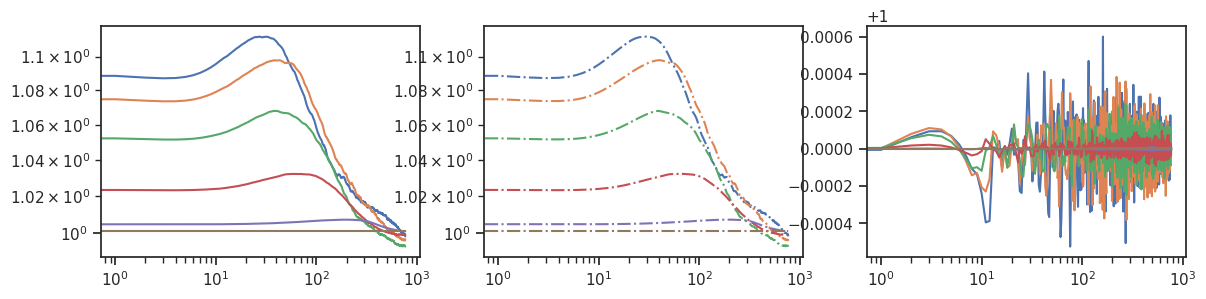

In [77]:
#| hide 

# import scipy.signal

#### adding smoothing filter ########

yhat = smooth_func(Bk_all)


f, a = plt.subplots(1, 3,  figsize = (14,3))
a[0].plot( np.array(Bk_all[sim_index, :, :]).T[:, ::10], '-')
a[1].plot( np.array(yhat[sim_index, :, :]).T[:, ::10], '-.')
a[2].plot( np.array(yhat[sim_index, :, :]).T[:, ::10]/np.array(Bk_all[sim_index, :, :]).T[:, ::10], '-')
a[0].set_xscale('log')
a[0].set_yscale('log')
a[1].set_xscale('log')
a[1].set_yscale('log')
a[2].set_xscale('log')
# a[2].set_yscale('log')

####################################

In [78]:
yhat.shape, Bk_all.shape

((50, 51, 768), (50, 51, 768))

In [79]:
np.array(yhat).T.shape

(768, 51, 50)

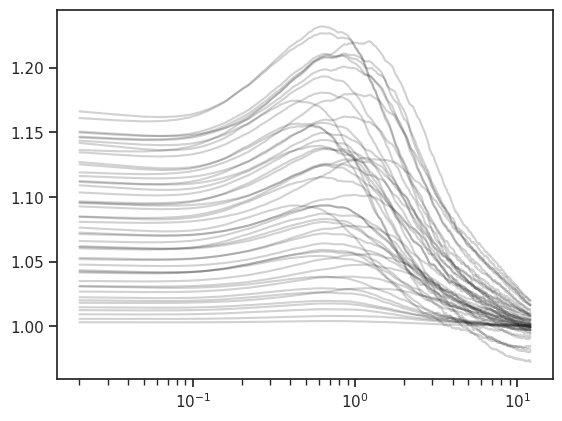

In [80]:
#| hide

z_index = 12

plt.figure(32)
for sim_index in range(Bk_all.shape[0]):
    plt.plot(k_all, Bk_all[sim_index, z_index, :], 'k', alpha=0.2)
   
plt.xscale('log')
plt.show()

(50, 51, 768) (768,) (51,) (50, 5)


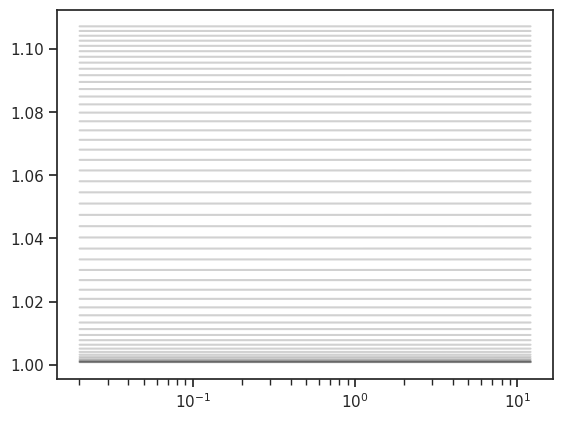

In [81]:
#| hide 

Bk_lin_all, k_lin_all, z_lin_all = load_boost_data_lin()
p_lin_all = load_params()

print(Bk_lin_all.shape, k_lin_all.shape, z_lin_all.shape, p_lin_all.shape)

sim_index = 1

plt.figure(32)
for z_index in range(Bk_lin_all.shape[1]):
    plt.plot(k_lin_all, Bk_lin_all[sim_index, z_index, :], 'k', alpha=0.2)
   
plt.xscale('log')
plt.show()

In [82]:
#| export

def sepia_data_format(design:np.array=None, # Params array of shape (num_simulation, num_params)
                     y_vals:np.array=None, # Shape (num_simulation, num_y_values)
                     y_ind:np.array=None # Shape (num_y_values,)
                     ) -> SepiaData: #Sepia data format
    sepia_data = SepiaData(t_sim=design, y_sim=y_vals, y_ind_sim=y_ind)
    return sepia_data

In [83]:
#| hide

z_index = 0
y_vals = Bk_all[:, z_index, :]
y_ind = np.arange(0, y_vals.shape[1])
sepia_data = sepia_data_format(p_all, y_vals, y_ind)
print(sepia_data)

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    50 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 



In [84]:
#| hide
import nbdev; nbdev.nbdev_export()